
# Understanding the StableDiffusionPipeline in Hugging Face's Diffusers: A Top-Down Approach

This notebook aims to understanding StableDiffusionPipeline code using a top-down approach. As a result, you can also find out how the diffusion model is generating images. We'll start with a broad overview and then delve into the specifics, providing actural code and pseudo-code to aid understanding.


Finally, as a practical application of our understanding, we'll embark on creating a minimalistic image generation library named PareDiffusers. We will realize image generation using functions from '[huggingface/diffusers](https://github.com/huggingface/diffusers/tree/main)', and then gradually replace small components with code written in torch to understand how works. Eventually, we will create a library called PareDiffusers, which has minimal functionality and does not use '[huggingface/diffusers](https://github.com/huggingface/diffusers/tree/main)'.


## Part 0: Setup

In [2]:
# Install diffusers
!pip install transformers diffusers accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 106.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 105.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.1/330.1 kB 70.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 110.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 96.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.0/169.0 kB 43.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.3.0
    Uninstalling fsspec-2023.3.0:
      Successfully uninstalled fsspec-2023.3.0
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.13.1
    Uninstalling huggingface-hub-0.13.1:
      Successfully uninstalled huggingface-hub-0.13.1
  Attempting uninstall: tokenizers
    Found existing installation: tok

      Successfully uninstalled tokenizers-0.12.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.21.3
    Uninstalling transformers-4.21.3:
      Successfully uninstalled transformers-4.21.3


In [ ]:
import torch
from torchvision.transforms import ToPILImage

device = torch.device("cuda")
dtype = torch.float16

def tensor_to_image(tensor):
	return ToPILImage()(tensor.detach().cpu())

## Part 1: Running the StableDiffusionPipeline to generate images from text

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

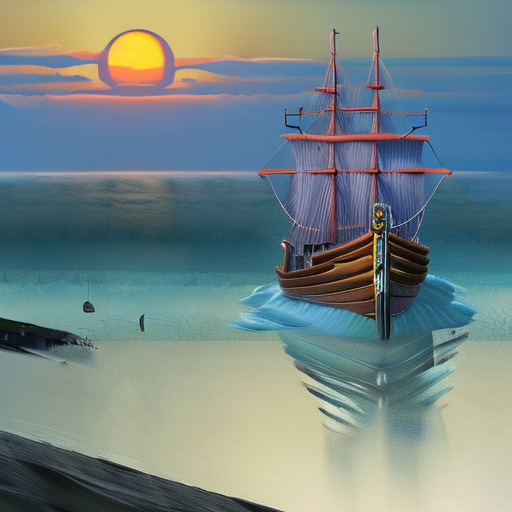

In [21]:
import torch
from diffusers import StableDiffusionPipeline

device = torch.device("cuda")
dtype = torch.float16

pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2").to(
	device=device,
	dtype=dtype,
)
prompt = "painting depicting the sea, sunrise, ship, artstation, 4k, concept art"

image = pipe(prompt, width=512, height=512).images[0]
display(image)

The above code is a quickstart to generating an image from text using the StableDiffusionPipeline. Let's break down what each part does:

1. **Importing the Library**: We import the `StableDiffusionPipeline` class from the diffusers library.
2. **Loading the Model**: `StableDiffusionPipeline.from_pretrained` is used to load a pre-trained version of the stable diffusion model.
3. **Setting Device**: `.to("cuda")` moves our model to the GPU for faster processing.
4. **Creating a Prompt**: `prompt` variable holds the textual description of the image you want to generate.
5. **Generating the Image**: The `pipe(prompt)` call generates the image, which is then accessed via `.images[0]`.
6. **Displaying the Image**: Finally, `display(image)` shows the generated image.

Now that we've seen the pipeline in action, let's dive into its internal workings.

## Part 2: Understanding the StableDiffusionPipeline Structure

Code of the StableDiffusionPipeline is available in the [here](https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py).

The method which generate image is the [__call__](https://github.com/huggingface/diffusers/blob/79c380bc80051d8f82a38c3a7df6f8f4efd1633d/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py#L775C5-L1063C99).


The code below has been simplified to allow only image generation from the prompt.

- batch_size is fixed to 1 and cannot be changed.
- num_images_per_prompt is fixed to 1 and cannot be changed.

In addition, various parameters and functions will be deleted to make txt2img possible at the bare minimum.



  0%|          | 0/50 [00:00<?, ?it/s]

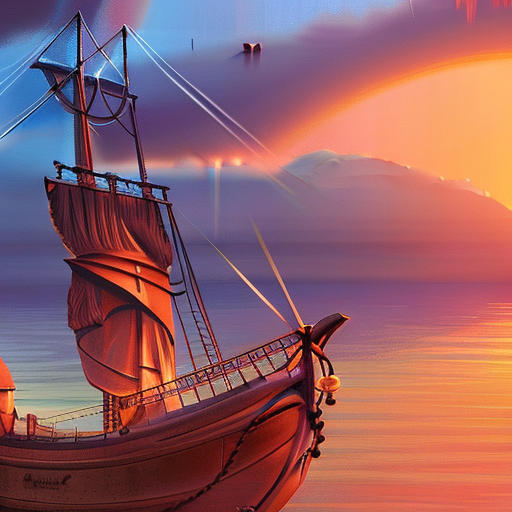

In [22]:
def retrieve_timesteps(
		scheduler,
		num_inference_steps=None,
):
	scheduler.set_timesteps(num_inference_steps, device=pipe.device)
	timesteps = scheduler.timesteps
	return timesteps, num_inference_steps


@torch.no_grad()
def txt2img(
		prompt="",
		height=512,
		width=512,
		num_inference_steps=50,
		timesteps=None,
		guidance_scale=7.5,
		negative_prompt=None,
		num_images_per_prompt=1,
		generator=None,
		latents=None,
		prompt_embeds=None,
		negative_prompt_embeds=None,
		guidance_rescale=0.0,
):
	pipe._guidance_scale = guidance_scale
	pipe._guidance_rescale = guidance_rescale
	pipe._clip_skip = None
	pipe._cross_attention_kwargs = None
	pipe._interrupt = False

	device = pipe._execution_device

	# 3. Encode input prompt
	prompt_embeds, negative_prompt_embeds = pipe.encode_prompt(
		prompt,
		device,
		num_images_per_prompt,
		pipe.do_classifier_free_guidance,
		negative_prompt,
	)

	prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])

	# 4. Prepare timesteps
	timesteps, num_inference_steps = retrieve_timesteps(
		pipe.scheduler, num_inference_steps
	)

	# 5. Prepare latent variables
	num_channels_latents = pipe.unet.config.in_channels
	latents = pipe.prepare_latents(
		1,
		num_channels_latents,
		height,
		width,
		prompt_embeds.dtype,
		device,
		generator,
		latents,
	)

	# 7. Denoising loop
	num_warmup_steps = len(timesteps) - \
		num_inference_steps * pipe.scheduler.order
	pipe._num_timesteps = len(timesteps)
	with pipe.progress_bar(total=num_inference_steps) as progress_bar:
		for i, t in enumerate(timesteps):
			if pipe.interrupt:
				continue

			# expand the latents if we are doing classifier free guidance
			latent_model_input = torch.cat(
				[latents] * 2) if pipe.do_classifier_free_guidance else latents
			latent_model_input = pipe.scheduler.scale_model_input(
				latent_model_input, t)

			# predict the noise residual
			noise_pred = pipe.unet(
				latent_model_input,
				t,
				encoder_hidden_states=prompt_embeds,
				return_dict=False,
			)[0]

			# perform guidance
			noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
			noise_pred = noise_pred_uncond + pipe.guidance_scale * \
				(noise_pred_text - noise_pred_uncond)

			# compute the previous noisy sample x_t -> x_t-1
			latents = pipe.scheduler.step(
				noise_pred, t, latents, return_dict=False
			)[0]

			# call the callback, if provided
			if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % pipe.scheduler.order == 0):
				progress_bar.update()

	image = pipe.vae.decode(latents / pipe.vae.config.scaling_factor, return_dict=False, generator=generator)[0]
	do_denormalize = [True] * image.shape[0]
	image = pipe.image_processor.postprocess(
		image, output_type="pil", do_denormalize=do_denormalize
	)
	return image


prompt = "painting depicting the sea, sunrise, ship, artstation, 4k, concept art"

image = txt2img(prompt=prompt)[0]
display(image)

By reading the above code, we can understand the flow to generate an image, so next, I will divide the image generation process into four steps: 

1. encode_prompt
2. get_latents
3. denoise
4. vae_decode.

### Part 2.1: encode_prompt
Prompt is text data so we need to convert it to data which model can handle. Thus, by encode_prompt, we convert it to a vector that represents the meaning of prompt.

#### Check pipe.encode_prompt return value


In [29]:
original_prompt_embeds, original_negative_prompt_embeds = pipe.encode_prompt(
	prompt,
	device,
	1,
	pipe.do_classifier_free_guidance,
	None,
)

print("prompt_embeds.shape", original_prompt_embeds.shape)
print(original_prompt_embeds)
print()
print("negative_prompt_embeds.shape", original_negative_prompt_embeds.shape)
print(original_negative_prompt_embeds)
print()

original_prompt_embeds = torch.cat([original_negative_prompt_embeds, original_prompt_embeds])
print("\nAfter concatenates, prompt_embeds.shape", original_prompt_embeds.shape)
print(original_prompt_embeds)


prompt_embeds.shape torch.Size([1, 77, 1024])
tensor([[[-0.3135, -0.4475, -0.0082,  ...,  0.2544, -0.0326, -0.2959],
         [ 0.6050, -0.9858, -0.6758,  ...,  1.6953, -0.1364, -0.3333],
         [-0.1305, -0.3596, -0.1381,  ...,  0.5254, -0.8174,  0.8154],
         ...,
         [ 0.4783, -1.6445,  0.7104,  ..., -0.0329, -0.2935,  0.4041],
         [ 0.4761, -1.6924,  0.7217,  ..., -0.2120, -0.3604,  0.5034],
         [ 0.5850, -2.2852,  0.3594,  ..., -0.2229,  0.1344,  0.7227]]],
       device='cuda:0', dtype=torch.float16, grad_fn=<ViewBackward0>)

negative_prompt_embeds.shape torch.Size([1, 77, 1024])
tensor([[[-3.1348e-01, -4.4751e-01, -8.1558e-03,  ...,  2.5439e-01,
          -3.2593e-02, -2.9590e-01],
         [ 1.4102e+00,  8.4686e-03, -4.2993e-01,  ...,  1.0361e+00,
          -6.7529e-01,  1.5010e+00],
         [ 1.8662e+00, -1.0908e+00, -1.0586e+00,  ...,  2.0312e+00,
          -1.1436e+00, -1.8933e-01],
         ...,
         [ 2.8915e-03, -1.5000e+00, -3.8818e-01,  ..., -1

In [26]:
prompt = pipe.maybe_convert_prompt(prompt, pipe.tokenizer)
prompt

'painting depicting the sea, sunrise, ship, artstation, 4k, concept art'

In [30]:
def encode_prompt(prompt):
	text_inputs = pipe.tokenizer(
		prompt,
		padding="max_length",
		max_length=pipe.tokenizer.model_max_length,
		truncation=True,
		return_tensors="pt",
	)
	text_input_ids = text_inputs.input_ids

	attention_mask = None

	prompt_embeds = pipe.text_encoder(text_input_ids.to(device), attention_mask=attention_mask)
	prompt_embeds = prompt_embeds[0]

	prompt_embeds_dtype = pipe.text_encoder.dtype
	prompt_embeds = prompt_embeds.to(dtype=prompt_embeds_dtype, device=device)

	bs_embed, seq_len, _ = prompt_embeds.shape
	# duplicate text embeddings for each generation per prompt, using mps friendly method
	prompt_embeds = prompt_embeds.repeat(1, 1, 1)
	prompt_embeds = prompt_embeds.view(bs_embed * 1, seq_len, -1)

	# get unconditional embeddings for classifier free guidance
	uncond_tokens = [""] * 1

	# textual inversion: procecss multi-vector tokens if necessary
	uncond_tokens = pipe.maybe_convert_prompt(uncond_tokens, pipe.tokenizer)

	max_length = prompt_embeds.shape[1]
	uncond_input = pipe.tokenizer(
		uncond_tokens,
		padding="max_length",
		max_length=max_length,
		truncation=True,
		return_tensors="pt",
	)

	attention_mask = None

	negative_prompt_embeds = pipe.text_encoder(
		uncond_input.input_ids.to(device),
		attention_mask=attention_mask,
	)
	negative_prompt_embeds = negative_prompt_embeds[0]

	# duplicate unconditional embeddings for each generation per prompt, using mps friendly method
	seq_len = negative_prompt_embeds.shape[1]

	negative_prompt_embeds = negative_prompt_embeds.to(dtype=prompt_embeds_dtype, device=device)

	negative_prompt_embeds = negative_prompt_embeds.repeat(1, 1, 1)
	negative_prompt_embeds = negative_prompt_embeds.view(1, seq_len, -1)

	return prompt_embeds, negative_prompt_embeds


prompt = "painting depicting the sea, sunrise, ship, artstation, 4k, concept art"
prompt_embeds, negative_prompt_embeds = encode_prompt(prompt)

print("prompt_embeds.shape", prompt_embeds.shape)
print(prompt_embeds)
print()
print("negative_prompt_embeds.shape", negative_prompt_embeds.shape)
print(negative_prompt_embeds)

prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])
print("\nAfter concatenates, prompt_embeds.shape", prompt_embeds.shape)
print(prompt_embeds)

prompt_embeds.shape torch.Size([1, 77, 1024])
tensor([[[-0.3135, -0.4475, -0.0082,  ...,  0.2544, -0.0326, -0.2959],
         [ 0.6050, -0.9858, -0.6758,  ...,  1.6953, -0.1364, -0.3333],
         [-0.1305, -0.3596, -0.1381,  ...,  0.5254, -0.8174,  0.8154],
         ...,
         [ 0.4783, -1.6445,  0.7104,  ..., -0.0329, -0.2935,  0.4041],
         [ 0.4761, -1.6924,  0.7217,  ..., -0.2120, -0.3604,  0.5034],
         [ 0.5850, -2.2852,  0.3594,  ..., -0.2229,  0.1344,  0.7227]]],
       device='cuda:0', dtype=torch.float16, grad_fn=<ViewBackward0>)

negative_prompt_embeds.shape torch.Size([1, 77, 1024])
tensor([[[-3.1348e-01, -4.4751e-01, -8.1558e-03,  ...,  2.5439e-01,
          -3.2593e-02, -2.9590e-01],
         [ 1.4102e+00,  8.4686e-03, -4.2993e-01,  ...,  1.0361e+00,
          -6.7529e-01,  1.5010e+00],
         [ 1.8662e+00, -1.0908e+00, -1.0586e+00,  ...,  2.0312e+00,
          -1.1436e+00, -1.8933e-01],
         ...,
         [ 2.8915e-03, -1.5000e+00, -3.8818e-01,  ..., -1

In [32]:
# Check equal to original
print("Equal to original_prompt_embeds:", torch.equal(original_prompt_embeds, prompt_embeds))

Equal to original_prompt_embeds: True


#### Overwrite pipe.encode_prompt of txt2img

  0%|          | 0/50 [00:00<?, ?it/s]

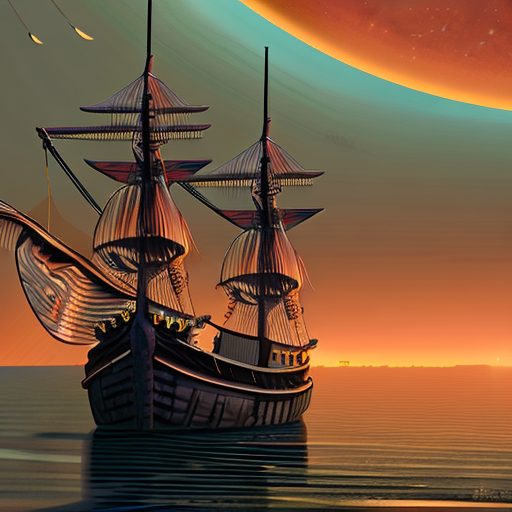

In [33]:
def retrieve_timesteps(
		scheduler,
		num_inference_steps=None,
):
	scheduler.set_timesteps(num_inference_steps, device=pipe.device)
	timesteps = scheduler.timesteps
	return timesteps, num_inference_steps


@torch.no_grad()
def txt2img(
		prompt="",
		height=512,
		width=512,
		num_inference_steps=50,
		timesteps=None,
		guidance_scale=7.5,
		generator=None,
		latents=None,
		prompt_embeds=None,
		negative_prompt_embeds=None,
		guidance_rescale=0.0,
):
	pipe._guidance_scale = guidance_scale
	pipe._guidance_rescale = guidance_rescale
	pipe._clip_skip = None
	pipe._cross_attention_kwargs = None
	pipe._interrupt = False

	device = pipe._execution_device

	# 3. OVERWRITE Encode input prompt
	prompt_embeds, negative_prompt_embeds = encode_prompt(prompt)

	prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])

	# 4. Prepare timesteps
	timesteps, num_inference_steps = retrieve_timesteps(
		pipe.scheduler, num_inference_steps
	)

	# 5. Prepare latent variables
	num_channels_latents = pipe.unet.config.in_channels
	latents = pipe.prepare_latents(
		1,
		num_channels_latents,
		height,
		width,
		prompt_embeds.dtype,
		device,
		generator,
		latents,
	)

	# 7. Denoising loop
	num_warmup_steps = len(timesteps) - \
		num_inference_steps * pipe.scheduler.order
	pipe._num_timesteps = len(timesteps)
	with pipe.progress_bar(total=num_inference_steps) as progress_bar:
		for i, t in enumerate(timesteps):
			if pipe.interrupt:
				continue

			# expand the latents if we are doing classifier free guidance
			latent_model_input = torch.cat(
				[latents] * 2) if pipe.do_classifier_free_guidance else latents
			latent_model_input = pipe.scheduler.scale_model_input(
				latent_model_input, t)

			# predict the noise residual
			noise_pred = pipe.unet(
				latent_model_input,
				t,
				encoder_hidden_states=prompt_embeds,
				return_dict=False,
			)[0]

			# perform guidance
			noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
			noise_pred = noise_pred_uncond + pipe.guidance_scale * \
				(noise_pred_text - noise_pred_uncond)

			# compute the previous noisy sample x_t -> x_t-1
			latents = pipe.scheduler.step(
				noise_pred, t, latents, return_dict=False
			)[0]

			# call the callback, if provided
			if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % pipe.scheduler.order == 0):
				progress_bar.update()

	image = pipe.vae.decode(latents / pipe.vae.config.scaling_factor, return_dict=False, generator=generator)[0]
	do_denormalize = [True] * image.shape[0]
	image = pipe.image_processor.postprocess(
		image, output_type="pil", do_denormalize=do_denormalize
	)
	return image


prompt = "painting depicting the sea, sunrise, ship, artstation, 4k, concept art"

image = txt2img(prompt=prompt)[0]
display(image)

### Part 2.2: get_latent
latent is a tensor of size [batch_size, 1, width, height] and is initialized with random values. Diffusion models gradually denoise this latent to generate an image.

torch.Size([4, 64, 64])


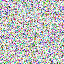

In [4]:
def get_latent(width, height):
	return torch.randn((4, width // 8, height // 8)).to(
		device=device, dtype=dtype
	)

width = 512
height = 512
latent = get_latent(width, height)
# latents = latent.unsqueeze(dim=0) # Shape: (1, 4, 64, 64)

print(latent.shape)
display(tensor_to_image(latent))

#### Overwrite pipe.prepare_latents of txt2img

  0%|          | 0/50 [00:00<?, ?it/s]

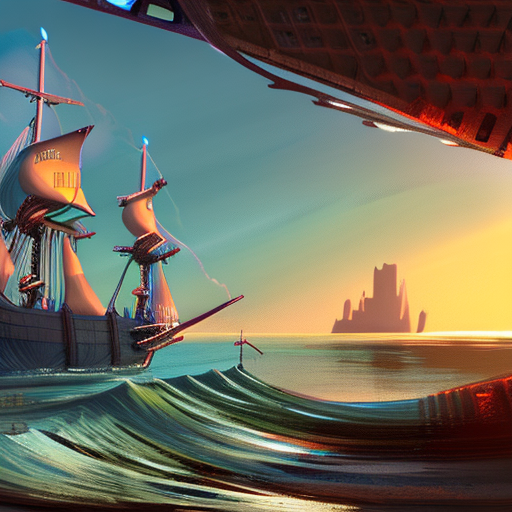

In [34]:
def retrieve_timesteps(
		scheduler,
		num_inference_steps=None,
):
	scheduler.set_timesteps(num_inference_steps, device=pipe.device)
	timesteps = scheduler.timesteps
	return timesteps, num_inference_steps


@torch.no_grad()
def txt2img(
		prompt="",
		height=512,
		width=512,
		num_inference_steps=50,
		timesteps=None,
		guidance_scale=7.5,
		generator=None,
		latents=None,
		prompt_embeds=None,
		negative_prompt_embeds=None,
		guidance_rescale=0.0,
):
	pipe._guidance_scale = guidance_scale
	pipe._guidance_rescale = guidance_rescale
	pipe._clip_skip = None
	pipe._cross_attention_kwargs = None
	pipe._interrupt = False

	# 3. OVERWRITE Encode input prompt
	prompt_embeds, negative_prompt_embeds = encode_prompt(prompt)

	prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])

	# 4. Prepare timesteps
	timesteps, num_inference_steps = retrieve_timesteps(
		pipe.scheduler, num_inference_steps
	)

	# 5. OVERWRITE Prepare latent variables
	latent = get_latent(width, height) # Shape: (4, 64, 64)
	latents = latent.unsqueeze(dim=0) # Shape: (1, 4, 64, 64)

	# 7. Denoising loop
	num_warmup_steps = len(timesteps) - \
		num_inference_steps * pipe.scheduler.order
	pipe._num_timesteps = len(timesteps)
	with pipe.progress_bar(total=num_inference_steps) as progress_bar:
		for i, t in enumerate(timesteps):
			if pipe.interrupt:
				continue

			# expand the latents if we are doing classifier free guidance
			latent_model_input = torch.cat(
				[latents] * 2) if pipe.do_classifier_free_guidance else latents
			latent_model_input = pipe.scheduler.scale_model_input(
				latent_model_input, t)

			# predict the noise residual
			noise_pred = pipe.unet(
				latent_model_input,
				t,
				encoder_hidden_states=prompt_embeds,
				return_dict=False,
			)[0]

			# perform guidance
			noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
			noise_pred = noise_pred_uncond + pipe.guidance_scale * \
				(noise_pred_text - noise_pred_uncond)

			# compute the previous noisy sample x_t -> x_t-1
			latents = pipe.scheduler.step(
				noise_pred, t, latents, return_dict=False
			)[0]

			# call the callback, if provided
			if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % pipe.scheduler.order == 0):
				progress_bar.update()

	image = pipe.vae.decode(latents / pipe.vae.config.scaling_factor, return_dict=False, generator=generator)[0]
	do_denormalize = [True] * image.shape[0]
	image = pipe.image_processor.postprocess(
		image, output_type="pil", do_denormalize=do_denormalize
	)
	return image


prompt = "painting depicting the sea, sunrise, ship, artstation, 4k, concept art"

image = txt2img(prompt=prompt)[0]
display(image)

### Part 2.3: get_condition_image

In [35]:
num_inference_steps = 50

def retrieve_timesteps(
		scheduler,
		num_inference_steps=None,
):
	scheduler.set_timesteps(num_inference_steps, device=pipe.device)
	timesteps = scheduler.timesteps
	return timesteps, num_inference_steps

timesteps, num_inference_steps = retrieve_timesteps(
	pipe.scheduler, num_inference_steps
)

print("timesteps", timesteps)
print("num_inference_steps", num_inference_steps)

timesteps tensor([981, 961, 941, 921, 901, 881, 861, 841, 821, 801, 781, 761, 741, 721,
        701, 681, 661, 641, 621, 601, 581, 561, 541, 521, 501, 481, 461, 441,
        421, 401, 381, 361, 341, 321, 301, 281, 261, 241, 221, 201, 181, 161,
        141, 121, 101,  81,  61,  41,  21,   1], device='cuda:0')
num_inference_steps 50


In [1]:
num_warmup_steps = len(timesteps) - \
	num_inference_steps * pipe.scheduler.order
pipe._num_timesteps = len(timesteps)

print("num_warmup_steps", num_warmup_steps)
print("pipe._num_timesteps", pipe._num_timesteps)

NameError: name 'timesteps' is not defined